In [2]:
# %matplotlib widget
# %matplotlib tk
import godot

import numpy as np
from godot.core import util
import matplotlib.pyplot as plt
import pickle


# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

import os
os.makedirs('./output/',exist_ok = True)

import mani_rain
from mani.StateEvaluator import SEEnum
from tqdm import tqdm

In [3]:
class data_generator:
    def __init__(self, year, station, filepath='./output/year_sim', bandwidth=50e6):
        lut = {'AAU':SEEnum.CLEAR_MOON_AAU, 'NN11':SEEnum.CLEAR_MOON_NN}
        self._load_data(filepath, year)

        self.station_name = station

        self.condition = self.res.above_elev(station+'_elev', 10.0) & self.res.has([lut[station]])
        self.bandwidth = bandwidth

        self.set_link()
    
    def _load_data(self, filepath, year):
        filename = filepath+'/one_year_' + str(year) + '.pickle'
        with open(filename, 'rb') as f:
            self.res = pickle.load(f)
        self.res.add_los_coloumns()

    def set_science_rate_day(self, sc_rate_byte):
        sc_rate_bit = sc_rate_byte * 8
        sc_rate_bit_per_day = sc_rate_bit / (60 * 60 * 24)
        self.science_rate = sc_rate_bit_per_day / np.mean(self.res.has([SEEnum.SUN_ON_MOON]))

    def set_target_data_rate(self, target_data_rate = 40e6):
        self.target_data_rate = target_data_rate
        self.full_data_rate = self.link.dvb_s2_fixed_rate(100, target_data_rate)

    def set_gateway_rate(self, gateway_rate = 16e6):
        self.gw_rate = gateway_rate
    
    def set_link(self):
        model_dict = {'AAU':mani_rain.rain.aau_ma_model,'NN11':mani_rain.rain.nn_ma_model}
        station_dict = {'AAU':mani_rain.aalborg, 'NN11':mani_rain.new_norcia}

        mrm = mani_rain.markov_rain(station_dict[self.station_name], model_dict[self.station_name])
        self.link = mani_rain.link_budget_markov(station_dict[self.station_name], mrm, self.bandwidth, link_margin = 0)

    def get_rates(self):
        return self.full_data_rate, self.science_rate, self.gw_rate
    
    def simulate(self):
        res = self.res
        stat = self.station_name

        st_snrs = np.empty(res.get_length())
        st_rates = np.empty(res.get_length())

        for i in tqdm(range(res.get_length())):
            dist = res.df.iloc[i][stat+'_dist'] * 1e3
            elev = res.df.iloc[i][stat+'_elev']
            if self.condition[i]:
                st_snrs[i] = self.link.snr_at_t(dist, elev)
                st_rates[i] = self.link.dvb_s2_fixed_rate(st_snrs[i], self.full_data_rate)
            else:
                st_snrs[i] = np.nan
                st_rates[i] = 0

        self.gw_los = res.has([SEEnum.LOS_GW])
        self.comm_los = self.condition
        self.sun_on_moon = res.has([SEEnum.SUN_ON_MOON])
        self.st_rates = st_rates
        self.st_snrs = st_snrs

        return st_rates, st_snrs

    def get_outage_probability(self):
        #Following: Outage counter
        print(len(self.condition))
        print(len(self.st_rates))
        outage_counter = np.sum(self.condition & (self.st_rates == 0))
        outage_prob = (outage_counter/len(self.condition))
        print(f"Num samples: {len(self.condition)}, outages: {outage_counter}, outage prob: {outage_prob}")
        return outage_prob
    
    def plot_time(self):
        fig = plt.figure(figsize=(15, 4))
        ax0, ax1 = fig.subplots(1,2, sharex=True)
        ax0.plot(self.st_snrs)
        ax1.step(range(len(self.st_rates)), self.st_rates / 1e6, label = 'gs')
        ax1.step(range(len(self.gw_los)), self.gw_los * self.gw_rate / 1e6, label = 'gw')
        mean_rate = np.mean(self.st_rates[self.condition == True])
        ax1.axhline(mean_rate/1e6, color='tab:green', label='mean rate')
        ax1.set_ylabel('Rate Mbit')
        plt.show()

station = 'AAU'
science_rate_byte = 25 * 1e9
year = 2028
target_data_rates = {'AAU':60 * 1e6, 'NN11':404*1e6}
bandwidths = {'AAU':100e6, 'NN11':100e6}
dg = data_generator(year=year, station=station, bandwidth=bandwidths[station])
dg.set_science_rate_day(science_rate_byte)
dg.set_target_data_rate(target_data_rates[station])
dg.set_gateway_rate()
st_rates, st_snrs = dg.simulate()

rate = dg.link.dvb.modcod_at_rate(np.max(st_rates))
esno = rate.esno
print("Req snr:",esno)
rate = np.max(st_rates)
print("Rate:", rate)
print("dl/sc ratio:", rate/dg.science_rate)
print(f"Avg snr: {np.nanmean(st_snrs)}")

100%|██████████| 527041/527041 [00:46<00:00, 11291.97it/s]

Req snr: -1.24
Rate: 59677090.909090914
dl/sc ratio: 12.879172263048709
Avg snr: 5.436926629584223


527041
527041
Num samples: 527041, outages: 294, outage prob: 0.0005578313641633194
0.05578313641633194
Outage time: 293.39 min/year
Outage time: 0.20 days/year
5.436926629584223


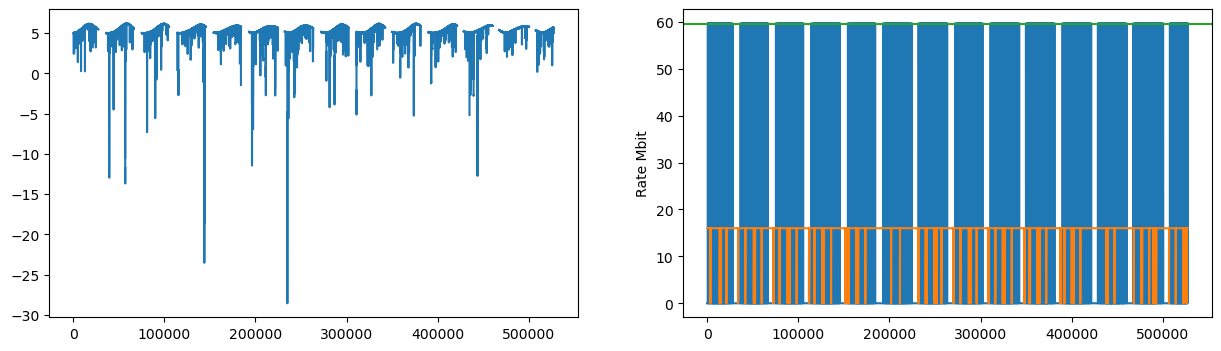

In [4]:
outage_prob = dg.get_outage_probability()
print(outage_prob*100)
print(f"Outage time: {1440*365.2425*outage_prob:.2f} min/year")
print(f"Outage time: {365.2425*outage_prob:.2f} days/year")
print(np.nanmean(st_snrs))
dg.plot_time()

/tmp/ipykernel_940512/1000246225.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


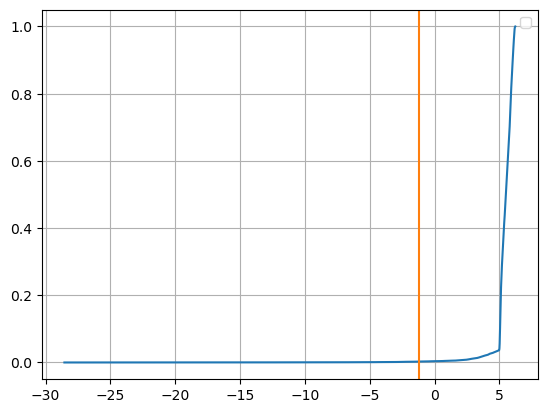

0.0026537409623872835


In [5]:
plt.figure()
arr = st_snrs[np.isnan(st_snrs) == False]
vals, bins = np.histogram(arr, bins=10000, weights=np.ones(len(arr)) / len(arr))
plt.plot(bins[:-1], np.cumsum(vals))
plt.grid()
plt.legend()
plt.axvline(esno, color='tab:orange')
plt.show()
print(np.sum(arr < esno)/len(arr))

In [6]:
def export(line_of_sight, outages, sunlight_on_moon, gateway_loss, science_rate, data_rate, gateway_rate, data_rate_full, filepath='./tmp/'):
    os.makedirs(filepath, exist_ok=True)
    with open(filepath+'los.pickle', 'wb') as f:
        pickle.dump(line_of_sight,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'outage_los.pickle', 'wb') as f:
        pickle.dump(outages,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'som.pickle', 'wb') as f:
        pickle.dump(sunlight_on_moon,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'rs.pickle', 'wb') as f:
        pickle.dump(science_rate,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'rd.pickle', 'wb') as f:
        pickle.dump(data_rate,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'rd_raw.pickle', 'wb') as f:
        pickle.dump(data_rate_full,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'gwr.pickle', 'wb') as f:
        pickle.dump(gateway_rate,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'gwlos.pickle', 'wb') as f:
        pickle.dump(gateway_loss,f,protocol=pickle.HIGHEST_PROTOCOL)

rd_full, rs, gwr = dg.get_rates()
n = 0
m = dg.res.get_length()

lut = {'AAU':'los_aau', 'NN11':'los_nn'}
los = dg.res[lut[dg.station_name]][n:n+m].values

outage_prob = np.sum((np.isnan(st_snrs) == False) & los & (st_snrs < esno))/np.sum(los)

rd_lowered =  rd_full * (1 - outage_prob) * 60
rs = rs * 60
gwr = gwr * 60
rd_full = rd_full * 60

outs = (st_rates > 0)[n:n+m]
som = dg.res.has([SEEnum.SUN_ON_MOON])[n:n+m].values
gwlos = dg.res.has([SEEnum.LOS_GW])[n:n+m].values
export(los, outs, som, gwlos, rs, rd_lowered, gwr, data_rate_full=rd_full, filepath=f'./station_{station}_rate_{int(rate)}/')